# Lab16 Flappy Bird Game
110065508 李丞恩

pygame 2.0.0會出錯，2.0.2就沒問題了。

In [1]:
import numpy as np
import sys
from gym.envs.toy_text import discrete

In [2]:
# four actions in the game
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

In [3]:
class GridworldEnv(discrete.DiscreteEnv):
    """
    Grid World environment from Sutton's Reinforcement Learning book chapter 4.
    You are an agent on an MxN grid and your goal is to reach the terminal
    state at the top left or the bottom right corner.
    For example, a 4x4 grid looks as follows:
    T  o  o  o
    o  x  o  o
    o  o  o  o
    o  o  o  T
    x is your position and T are the two terminal states.
    You can take actions in each direction (UP=0, RIGHT=1, DOWN=2, LEFT=3).
    Actions going off the edge leave you in your current state.
    You receive a reward of -1 at each step until you reach a terminal state.
    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, shape=[4, 4]):
        if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
            raise ValueError('shape argument must be a list/tuple of length 2')

        self.shape = shape

        nS = np.prod(shape)
        nA = 4

        MAX_Y = shape[0]
        MAX_X = shape[1]

        P = {}
        grid = np.arange(nS).reshape(shape)
        it = np.nditer(grid, flags=['multi_index'])

        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index

            P[s] = {a: [] for a in range(nA)}

            is_done = lambda s: s == 0 or s == (nS - 1)
            reward = 0.0 if is_done(s) else -1.0

            # We're stuck in a terminal state
            if is_done(s):
                P[s][UP] = [(1.0, s, reward, True)]
                P[s][RIGHT] = [(1.0, s, reward, True)]
                P[s][DOWN] = [(1.0, s, reward, True)]
                P[s][LEFT] = [(1.0, s, reward, True)]
            # Not a terminal state
            else:
                ns_up = s if y == 0 else s - MAX_X
                ns_right = s if x == (MAX_X - 1) else s + 1
                ns_down = s if y == (MAX_Y - 1) else s + MAX_X
                ns_left = s if x == 0 else s - 1
                P[s][UP] = [(1.0, ns_up, reward, is_done(ns_up))]
                P[s][RIGHT] = [(1.0, ns_right, reward, is_done(ns_right))]
                P[s][DOWN] = [(1.0, ns_down, reward, is_done(ns_down))]
                P[s][LEFT] = [(1.0, ns_left, reward, is_done(ns_left))]

            it.iternext()

        # Initial state distribution is uniform
        isd = np.ones(nS) / nS

        # We expose the model of the environment for educational purposes
        # This should not be used in any model-free learning algorithm
        self.P = P

        super(GridworldEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human', close=False):
        if close:
            return

        outfile = StringIO() if mode == 'ansi' else sys.stdout

        grid = np.arange(self.nS).reshape(self.shape)
        it = np.nditer(grid, flags=['multi_index'])
        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index

            if self.s == s:
                output = " x "
            elif s == 0 or s == self.nS - 1:
                output = " T "
            else:
                output = " o "

            if x == 0:
                output = output.lstrip()
            if x == self.shape[1] - 1:
                output = output.rstrip()

            outfile.write(output)

            if x == self.shape[1] - 1:
                outfile.write("\n")

            it.iternext()

In [4]:
env = GridworldEnv()

In [5]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """


    def one_step_lookahead(state, V):
        """
        Given an state, calculate the new value function V(s) based on the value iteration algorithm
        Args:
            state: represents each state in the Gridworld, an integer
            V: the current value function of the states(V(s)), the lengh is env.nS

        Returns:
            a new V(s)
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A

    V = np.zeros(env.nS)
    while True:
        delta = 0

        for s in range(env.nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function
            V[s] = best_action_value
            # Check if we can stop
        if delta < theta:
            break

    # Create a deterministic policy using the optimal value function
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s, best_action] = 1.0

    return policy, V


policy, v = value_iteration(env)

print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



In [6]:
import numpy as np
import sys
from gym.envs.toy_text import discrete

In [7]:
env = GridworldEnv()

In [8]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        delta = 0
        # For each state, perform a "full backup"
        for s in range(env.nS):
            v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                # For each action, look at the possible next states...
                for  prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value
                    v += action_prob * prob * (reward + discount_factor * V[next_state])
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
            
    return np.array(V)

In [9]:
def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI environment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """

    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    while True:
        # Evaluate the current policy
        V = policy_eval_fn(policy, env, discount_factor)
        
        # Will be set to false if we make any changes to the policy
        policy_stable = True
        
        # For each state...
        for s in range(env.nS):
            # The best action we would take under the current policy
            chosen_a = np.argmax(policy[s])
            
            # Find the best action by one-step lookahead
            # Ties are resolved arbitarily
            action_values = one_step_lookahead(s, V)
            best_a = np.argmax(action_values)
            
            # Greedily update the policy
            if chosen_a != best_a:
                policy_stable = False
            policy[s] = np.eye(env.nA)[best_a]
        
        # If the policy is stable we've found an optimal policy. Return it
        if policy_stable:
            return policy, V

In [10]:
policy, v = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



In [11]:
from ple.games.flappybird import FlappyBird
from ple import PLE
import matplotlib.pyplot as plt
import os
import numpy as np

%matplotlib inline
os.environ["SDL_VIDEODRIVER"] = "dummy"  # this line disable pop-out window
game = FlappyBird()
env = PLE(game, fps=30, display_screen=False)  # environment interface to game
env.reset_game()

pygame 2.0.2 (SDL 2.0.16, Python 3.8.11)
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [12]:
# return a dictionary whose key is action description and value is action index
print(game.actions)
# return a list of action index (include None)
print(env.getActionSet())

{'up': 119}
[119, None]


In [13]:
# a dictionary describe state
'''
    player y position.
    players velocity.
    next pipe distance to player
    next pipe top y position
    next pipe bottom y position
    next next pipe distance to player
    next next pipe top y position
    next next pipe bottom y position
'''
game.getGameState()  

{'player_y': 256,
 'player_vel': 0,
 'next_pipe_dist_to_player': 309.0,
 'next_pipe_top_y': 144,
 'next_pipe_bottom_y': 244,
 'next_next_pipe_dist_to_player': 453.0,
 'next_next_pipe_top_y': 160,
 'next_next_pipe_bottom_y': 260}

In [14]:
import math
import copy
from collections import defaultdict
MIN_EXPLORING_RATE = 0.01
MIN_LEARNING_RATE = 0.5


class Agent:

    def __init__(self,
                 bucket_range_per_feature,
                 num_action,
                 t=0,
                 discount_factor=0.99):
        self.update_parameters(t)  # init explore rate and learning rate
        self.q_table = defaultdict(lambda: np.zeros(num_action))
        self.discount_factor = discount_factor
        self.num_action = num_action

        # how to discretize each feature in a state
        # the higher each value, less time to train but with worser performance
        # e.g. if range = 2, feature with value 1 is equal to feature with value 0 bacause int(1/2) = int(0/2)
        self.bucket_range_per_feature = bucket_range_per_feature

    def select_action(self, state):
        # epsilon-greedy
        state_idx = self.get_state_idx(state)
        if np.random.rand() < self.exploring_rate:
            action = np.random.choice(num_action)  # Select a random action
        else:
            action = np.argmax(
                self.q_table[state_idx])  # Select the action with the highest q
        return action

    def update_policy(self, state, action, reward, state_prime):
        state_idx = self.get_state_idx(state)
        state_prime_idx = self.get_state_idx(state_prime)
        # Update Q_value using Q-learning update rule
        best_q = np.max(self.q_table[state_prime_idx])
        self.q_table[state_idx][action] += self.learning_rate * (
            reward + self.discount_factor * best_q - self.q_table[state_idx][action])

    def get_state_idx(self, state):
        # instead of using absolute position of pipe, use relative position
        state = copy.deepcopy(state)
        state['next_next_pipe_bottom_y'] -= state['player_y']
        state['next_next_pipe_top_y'] -= state['player_y']
        state['next_pipe_bottom_y'] -= state['player_y']
        state['next_pipe_top_y'] -= state['player_y']

        # sort to make list converted from dict ordered in alphabet order
        state_key = [k for k, v in sorted(state.items())]

        # do bucketing to decrease state space to speed up training
        state_idx = []
        for key in state_key:
            state_idx.append(
                int(state[key] / self.bucket_range_per_feature[key]))
        return tuple(state_idx)

    def update_parameters(self, episode):
        self.exploring_rate = max(MIN_EXPLORING_RATE,
                                  min(0.5, 0.99**((episode) / 30)))
        self.learning_rate = max(MIN_LEARNING_RATE, min(0.5, 0.99
                                                        ** ((episode) / 30)))

    def shutdown_explore(self):
        # make action selection greedy
        self.exploring_rate = 0

In [15]:
num_action = len(env.getActionSet())
bucket_range_per_feature = {
  'next_next_pipe_bottom_y': 40,
  'next_next_pipe_dist_to_player': 512,
  'next_next_pipe_top_y': 40,
  'next_pipe_bottom_y': 20,
  'next_pipe_dist_to_player': 20,
  'next_pipe_top_y': 20,
  'player_vel': 4,
  'player_y': 16
}
# init agent
agent = Agent(bucket_range_per_feature, num_action)

In [16]:
import moviepy.editor as mpy


def make_anim(images, fps=60, true_image=False):
    duration = len(images) / fps

    def make_frame(t):
        try:
            x = images[int(len(images) / duration * t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x + 1) / 2 * 255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.fps = fps
    return clip

In [17]:
from IPython.display import Image, display

reward_per_epoch = []
lifetime_per_epoch = []
exploring_rates = []
learning_rates = []
print_every_episode = 500
show_gif_every_episode = 5000
NUM_EPISODE = 40000
for episode in range(0, NUM_EPISODE):

    # Reset the environment
    env.reset_game()

    # record frame
    frames = [env.getScreenRGB()]

    # for every 500 episodes, shutdown exploration to see performance of greedy action
    if episode % print_every_episode == 0:
        agent.shutdown_explore()

    # the initial state
    state = game.getGameState()
    # cumulate reward for this episode
    cum_reward = 0  
    t = 0

    while not env.game_over():

        # select an action
        action = agent.select_action(state)

        # execute the action and get reward
        # reward = +1 when pass a pipe, -5 when die
        reward = env.act(env.getActionSet()[action])  

        frames.append(env.getScreenRGB())

        # cumulate reward
        cum_reward += reward

        # observe the result
        state_prime = game.getGameState()  # get next state

        # update agent
        agent.update_policy(state, action, reward, state_prime)

        # Setting up for the next iteration
        state = state_prime
        t += 1

    # update exploring_rate and learning_rate
    agent.update_parameters(episode)

    if episode % print_every_episode == 0:
        print("Episode {} finished after {} time steps, cumulated reward: {}, exploring rate: {}, learning rate: {}".format(
            episode,
            t,
            cum_reward,
            agent.exploring_rate,
            agent.learning_rate
        ))
        reward_per_epoch.append(cum_reward)
        exploring_rates.append(agent.exploring_rate)
        learning_rates.append(agent.learning_rate)
        lifetime_per_epoch.append(t)

    # for every 5000 episode, record an animation
    if episode % show_gif_every_episode == 0:
        print("len frames:", len(frames))
        clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1))

Episode 0 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
len frames: 63
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 1000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 1500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 2000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 2500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.43277903725889943, learning rate: 0.5
Episode 3000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.3660323412732292, learning rate: 0.5
Episode 3500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.30957986252419073, learning rate: 0.5
Episode 4000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.26183394327157605, learning rate: 0.5
Episode 4500 finished after 62 time steps, cumulated reward: -5.0, exploring rate:

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 5500 finished after 67 time steps, cumulated reward: -4.0, exploring rate: 0.15841112426184903, learning rate: 0.5
Episode 6000 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.13397967485796172, learning rate: 0.5
Episode 6500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.11331624189077398, learning rate: 0.5
Episode 7000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.09583969128049684, learning rate: 0.5
Episode 7500 finished after 60 time steps, cumulated reward: -5.0, exploring rate: 0.08105851616218128, learning rate: 0.5
Episode 8000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.0685570138491429, learning rate: 0.5
Episode 8500 finished after 86 time steps, cumulated reward: -4.0, exploring rate: 0.05798359469728905, learning rate: 0.5
Episode 9000 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.04904089407128572, learning rate: 0.5
Episode 9500 fini

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 10500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.029670038450977102, learning rate: 0.5
Episode 11000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.02509408428990297, learning rate: 0.5
Episode 11500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.021223870922486707, learning rate: 0.5
Episode 12000 finished after 113 time steps, cumulated reward: -3.0, exploring rate: 0.017950553275045137, learning rate: 0.5
Episode 12500 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.015182073244652034, learning rate: 0.5
Episode 13000 finished after 129 time steps, cumulated reward: -3.0, exploring rate: 0.012840570676248398, learning rate: 0.5
Episode 13500 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.010860193639877882, learning rate: 0.5
Episode 14000 finished after 105 time steps, cumulated reward: -3.0, exploring rate: 0.01, learning rate: 0.5
Episode 14500 

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 15500 finished after 60 time steps, cumulated reward: -5.0, exploring rate: 0.01, learning rate: 0.5
Episode 16000 finished after 99 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 16500 finished after 627 time steps, cumulated reward: 10.0, exploring rate: 0.01, learning rate: 0.5
Episode 17000 finished after 168 time steps, cumulated reward: -2.0, exploring rate: 0.01, learning rate: 0.5
Episode 17500 finished after 401 time steps, cumulated reward: 4.0, exploring rate: 0.01, learning rate: 0.5
Episode 18000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.01, learning rate: 0.5
Episode 18500 finished after 213 time steps, cumulated reward: -1.0, exploring rate: 0.01, learning rate: 0.5
Episode 19000 finished after 211 time steps, cumulated reward: -1.0, exploring rate: 0.01, learning rate: 0.5
Episode 19500 finished after 140 time steps, cumulated reward: -2.0, exploring rate: 0.01, learning rate: 0.5
Episode 20000 

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 20500 finished after 73 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 21000 finished after 326 time steps, cumulated reward: 2.0, exploring rate: 0.01, learning rate: 0.5
Episode 21500 finished after 550 time steps, cumulated reward: 8.0, exploring rate: 0.01, learning rate: 0.5
Episode 22000 finished after 134 time steps, cumulated reward: -3.0, exploring rate: 0.01, learning rate: 0.5
Episode 22500 finished after 360 time steps, cumulated reward: 3.0, exploring rate: 0.01, learning rate: 0.5
Episode 23000 finished after 514 time steps, cumulated reward: 7.0, exploring rate: 0.01, learning rate: 0.5
Episode 23500 finished after 1038 time steps, cumulated reward: 21.0, exploring rate: 0.01, learning rate: 0.5
Episode 24000 finished after 149 time steps, cumulated reward: -2.0, exploring rate: 0.01, learning rate: 0.5
Episode 24500 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 25000 f

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 25500 finished after 2322 time steps, cumulated reward: 55.0, exploring rate: 0.01, learning rate: 0.5
Episode 26000 finished after 134 time steps, cumulated reward: -3.0, exploring rate: 0.01, learning rate: 0.5
Episode 26500 finished after 360 time steps, cumulated reward: 3.0, exploring rate: 0.01, learning rate: 0.5
Episode 27000 finished after 448 time steps, cumulated reward: 6.0, exploring rate: 0.01, learning rate: 0.5
Episode 27500 finished after 630 time steps, cumulated reward: 10.0, exploring rate: 0.01, learning rate: 0.5
Episode 28000 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 28500 finished after 324 time steps, cumulated reward: 2.0, exploring rate: 0.01, learning rate: 0.5
Episode 29000 finished after 211 time steps, cumulated reward: -1.0, exploring rate: 0.01, learning rate: 0.5
Episode 29500 finished after 627 time steps, cumulated reward: 10.0, exploring rate: 0.01, learning rate: 0.5
Episode 30000

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 30500 finished after 360 time steps, cumulated reward: 3.0, exploring rate: 0.01, learning rate: 0.5
Episode 31000 finished after 1228 time steps, cumulated reward: 26.0, exploring rate: 0.01, learning rate: 0.5
Episode 31500 finished after 663 time steps, cumulated reward: 11.0, exploring rate: 0.01, learning rate: 0.5
Episode 32000 finished after 1870 time steps, cumulated reward: 43.0, exploring rate: 0.01, learning rate: 0.5
Episode 32500 finished after 776 time steps, cumulated reward: 14.0, exploring rate: 0.01, learning rate: 0.5
Episode 33000 finished after 740 time steps, cumulated reward: 13.0, exploring rate: 0.01, learning rate: 0.5
Episode 33500 finished after 776 time steps, cumulated reward: 14.0, exploring rate: 0.01, learning rate: 0.5
Episode 34000 finished after 2584 time steps, cumulated reward: 62.0, exploring rate: 0.01, learning rate: 0.5
Episode 34500 finished after 1683 time steps, cumulated reward: 38.0, exploring rate: 0.01, learning rate: 0.5
Episode

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 35500 finished after 3524 time steps, cumulated reward: 87.0, exploring rate: 0.01, learning rate: 0.5
Episode 36000 finished after 73 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 36500 finished after 49 time steps, cumulated reward: -5.0, exploring rate: 0.01, learning rate: 0.5
Episode 37000 finished after 586 time steps, cumulated reward: 9.0, exploring rate: 0.01, learning rate: 0.5
Episode 37500 finished after 2548 time steps, cumulated reward: 61.0, exploring rate: 0.01, learning rate: 0.5
Episode 38000 finished after 247 time steps, cumulated reward: 0.0, exploring rate: 0.01, learning rate: 0.5
Episode 38500 finished after 4505 time steps, cumulated reward: 113.0, exploring rate: 0.01, learning rate: 0.5
Episode 39000 finished after 2584 time steps, cumulated reward: 62.0, exploring rate: 0.01, learning rate: 0.5
Episode 39500 finished after 17125 time steps, cumulated reward: 448.0, exploring rate: 0.01, learning rate: 0.5


In [18]:
def demo():
    # Reset the environment
    env.reset_game()

    # record frame
    frames = [env.getScreenRGB()]

    # shutdown exploration to see performance of greedy action
    agent.shutdown_explore()

    # the initial state
    state = game.getGameState()

    while not env.game_over():
        # select an action
        action = agent.select_action(state)

        # execute the action and get reward
        reward = env.act(env.getActionSet()[action])

        frames.append(env.getScreenRGB())

        # observe the result
        state_prime = game.getGameState()  # get next state

        # Setting up for the next iteration
        state = state_prime

    clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
    display(clip.ipython_display(fps=60, autoplay=1, loop=1))


demo()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


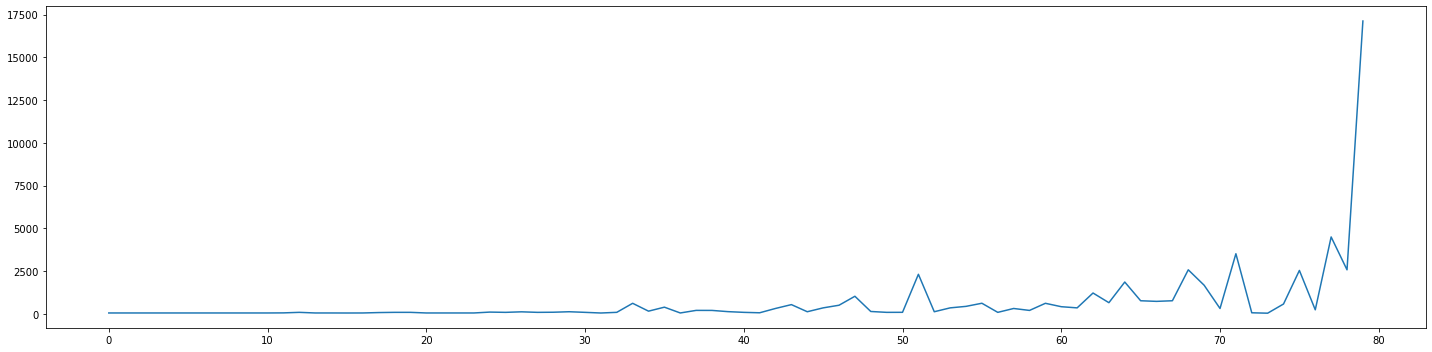

In [19]:
# plot life time against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(lifetime_per_epoch)), lifetime_per_epoch)
fig.tight_layout()
plt.show()

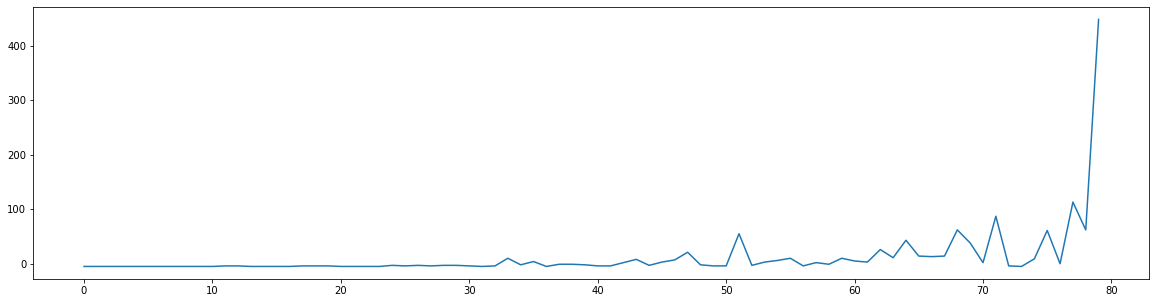

In [20]:
# plot reward against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(reward_per_epoch)), reward_per_epoch)
plt.show()